# README
Before starting to run all code, the trained model, tokenizer, and other needed stuff is saved to file. It is sufficient to run last 2/3 code blocks to try how the intent classifier works

In [2]:
### Download the data file from the github repo
# import wget
# url = 'https://raw.githubusercontent.com/clinc/oos-eval/master/data/data_full.json'
# wget.download(url)

In [3]:
### Load the data
# Data is divided into two sections: in-scope and out-of-scope.
# In-scope refers to data that is relevant to the intent classifier.
# Out-of-scope refers to data that is not relevant to the intent classifier.

# Both datasets are further divided into three sections: train, test, and val.


import numpy as np
import json
# Loading json data
with open('data_full.json') as file:
  data = json.loads(file.read())

# Loading out-of-scope intent data
val_oos = np.array(data['oos_val'])
train_oos = np.array(data['oos_train'])
test_oos = np.array(data['oos_test'])

# Loading other intents data
val_others = np.array(data['val'])
train_others = np.array(data['train'])
test_others = np.array(data['test'])

# Merging out-of-scope and other intent data
val = np.concatenate([val_oos,val_others])
train = np.concatenate([train_oos,train_others])
test = np.concatenate([test_oos,test_others])
data = np.concatenate([train,test,val])

# only use half the data for now, to speed up training
data = data
data = data.T

text = data[0]
labels = data[1]

In [4]:
### We split the data into a train and test set by ourselvel because the tutorial says so.

from sklearn.model_selection import train_test_split
train_txt,test_txt,train_labels,test_labels = train_test_split(text,labels,test_size = 0.3)

In [5]:
### We run a tokenizer on our dataset

from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
max_num_words = 40000

classes = np.unique(labels)

# create a tokenizer instance
tokenizer = Tokenizer(num_words=max_num_words)

# tokenize the data. This means assigning a unique number to each word
tokenizer.fit_on_texts(train_txt)

# the word index, which is a dictionary containing words as keys and their index as the value
word_index = tokenizer.word_index

2024-01-19 13:00:56.223918: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
### All data fed into the classifier need to be of the same shape, but since sentences have different lengths, we need to pad them to the same length.

ls=[]
for c in train_txt:
    ls.append(len(c.split()))
maxLen=int(np.percentile(ls, 98))

# convert the text to sequences of numbers, then pad the sequences so they're all the same length. padding is applied to the end of the sequences
train_sequences = tokenizer.texts_to_sequences(train_txt)
train_sequences = pad_sequences(train_sequences, maxlen=maxLen, padding='post')

test_sequences = tokenizer.texts_to_sequences(test_txt)
test_sequences = pad_sequences(test_sequences, maxlen=maxLen, padding='post')

In [7]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

# encode the labels as integers
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classes)

# convert integers to one hot encoded labels
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

# train encoder class labels. convert labels into one hot encoded labels
onehot_encoder.fit(integer_encoded)

# convert train label into encoded label, then into one hot encoded label
train_labels_encoded = label_encoder.transform(train_labels)
train_labels_encoded = train_labels_encoded.reshape(len(train_labels_encoded), 1)
train_labels_encoded = onehot_encoder.transform(train_labels_encoded)

# convert test label into encoded label, then into one hot encoded label
test_labels_encoded = label_encoder.transform(test_labels)
test_labels_encoded = test_labels_encoded.reshape(len(test_labels_encoded), 1)
test_labels_encoded = onehot_encoder.transform(test_labels_encoded)

In [8]:
### download glove, a pretrained word embedding model. short for global vectors
### file is fucking large gyatdammit - 300MB

# DO NOT RERUN
# import wget
# url ='https://www.dropbox.com/s/a247ju2qsczh0be/glove.6B.100d.txt?dl=1'
# wget.download(url)

In [9]:
# create a dictionary, where each word indexes its embedding

embeddings_index={}

with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [10]:
all_embs = np.stack(list(embeddings_index.values()))
emb_mean,emb_std = all_embs.mean(), all_embs.std()

num_words = min(max_num_words, len(word_index))+1
embedding_dim=len(embeddings_index['the'])

# just populate with random values in case there is a missing value
embedding_matrix = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))

# word encodings are sorted [1..n]
# loop through all (word, encoding) pairs and place it in the embedding matrix
for word, i in word_index.items():
    if i >= max_num_words:
        break
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [11]:
from tensorflow.keras.models import Sequential
from keras.initializers import Constant
from keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional, Embedding

# initialize a sequential model
model = Sequential()

# add an embedding layer. this layer will take the encoded input and the embedding matrix, and create the embedding layer
embedding_layer = Embedding(num_words, 100, input_length=train_sequences.shape[1], embeddings_initializer=Constant(embedding_matrix), trainable=False)
model.add(embedding_layer)

# add all other layers to classifier
model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
model.add(Dropout(0.3))
model.add(LSTM(256, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(classes.shape[0], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [14]:
# Train model
# Up to 20 epochs for best results
history = model.fit(train_sequences, train_labels_encoded, epochs = 14,
          batch_size = 64, shuffle=True,
          validation_data=[test_sequences, test_labels_encoded])

Epoch 1/14
260/260 [==============================] - 68s 236ms/step - loss: 4.6773 - acc: 0.0492 - val_loss: 3.8952 - val_acc: 0.0952
Epoch 2/14
260/260 [==============================] - 60s 232ms/step - loss: 3.3165 - acc: 0.1732 - val_loss: 2.2887 - val_acc: 0.3886
Epoch 3/14
260/260 [==============================] - 60s 230ms/step - loss: 2.2283 - acc: 0.3841 - val_loss: 1.4753 - val_acc: 0.6006
Epoch 4/14
260/260 [==============================] - 60s 231ms/step - loss: 1.5923 - acc: 0.5438 - val_loss: 1.1543 - val_acc: 0.6634
Epoch 5/14
260/260 [==============================] - 60s 232ms/step - loss: 1.2067 - acc: 0.6552 - val_loss: 0.9314 - val_acc: 0.7390
Epoch 6/14
260/260 [==============================] - 61s 235ms/step - loss: 1.0124 - acc: 0.7118 - val_loss: 0.7932 - val_acc: 0.7828
Epoch 7/14
260/260 [==============================] - 62s 238ms/step - loss: 0.8364 - acc: 0.7666 - val_loss: 0.7225 - val_acc: 0.8058
Epoch 8/14
260/260 [==============================] - 6

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the loss and accuracy of the model of the training and validation data over epochs
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

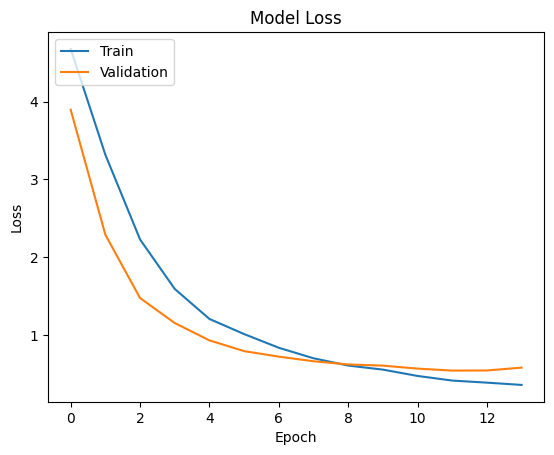

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the loss and accuracy of the model of the training and validation data over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
import pickle

# save the model
model.save('models/intents.keras')

# save the tokenizer, label encoder, and classes
with open('./utils/classes.pkl','wb') as file:
   pickle.dump(classes,file)

with open('./utils/tokenizer.pkl','wb') as file:
   pickle.dump(tokenizer,file)

with open('./utils/label_encoder.pkl','wb') as file:
   pickle.dump(label_encoder,file)

In [13]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# a class that takes in encoding/model components and returns the intent of a given text
class IntentClassifier:
    def __init__(self,classes,model,tokenizer,label_encoder):
        self.classes = classes
        self.classifier = model
        self.tokenizer = tokenizer
        self.label_encoder = label_encoder

    def get_intent(self,text):
        self.text = [text]
        self.test_keras = self.tokenizer.texts_to_sequences(self.text)
        self.test_keras_sequence = pad_sequences(self.test_keras, maxlen=16, padding='post')
        self.pred = self.classifier.predict(self.test_keras_sequence)
        return self.label_encoder.inverse_transform(np.argmax(self.pred,1))[0]

In [15]:
import pickle
from tensorflow.keras.models import load_model

### Start running code from here

# load the model
loaded_model = load_model('models/intents.keras')

# load the necessary supllementary components
with open('./utils/classes.pkl','rb') as file:
  classes = pickle.load(file)

with open('./utils/tokenizer.pkl','rb') as file:
  tokenizer = pickle.load(file)

with open('./utils/label_encoder.pkl','rb') as file:
  label_encoder = pickle.load(file)

In [17]:
# BEHOLD: THE CLASSIFIER

nlu = IntentClassifier(classes, loaded_model, tokenizer, label_encoder)
print(nlu.get_intent("Book me a Greek restaurant in Toronto"))

1/1 [==============================] - 0s 43ms/step
restaurant_suggestion
